# Workout Video Classifier

## Import

In [15]:
import kagglehub
from pathlib import Path
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as T
import torchvision.transforms.functional as F
import torchvision.models as models
from torchvision.models.video import r3d_18
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import random


## Download the dataset

In [16]:
# Download the dataset
path = kagglehub.dataset_download("hasyimabdillah/workoutfitness-video")
print("Dataset downloaded to:", path)

Using Colab cache for faster access to the 'workoutfitness-video' dataset.
Dataset downloaded to: /kaggle/input/workoutfitness-video


## 1. Data Analysis

### Initial scan of files to calculate metadata:

In [17]:
def scan_videos(root_dir_path):
    """
    This function initially scans the dataset and calculates metadata used for data analysis.
    """

    # Path to the dataset
    root_dir = Path(root_dir_path)

    video_extensions=(".mp4", ".avi", ".mov", ".mkv")
    # List to store video information
    data = []
    fps_list = []
    frame_sizes = []
    broken_files = []

    # Scan dataset
    for class_dir in root_dir.iterdir():
        if not class_dir.is_dir(): # skip non-directory entries
            continue
        class_name = class_dir.name

        for video_file in class_dir.iterdir(): # iterate over all files inside the class directory
            if video_file.suffix.lower() not in video_extensions:
                continue

            cap = cv2.VideoCapture(str(video_file))

            if not cap.isOpened():
                broken_files.append(str(video_file))
                continue

            # Read FPS and frame count
            fps = cap.get(cv2.CAP_PROP_FPS)
            frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)

            # Read first frame to get resolution
            ret, first_frame = cap.read()
            if not ret:
                broken_files.append(str(video_file))
                cap.release()
                continue

            h, w, c = first_frame.shape

            # Duration calculation
            duration_sec = frame_count / fps if fps > 0 else 0

            # Store values
            data.append({
                "class": class_name,
                "file_path": str(video_file),
                "duration_sec": duration_sec,
                "fps": fps,
                "num_frames": frame_count,
                "width": w,
                "height": h
            })

            cap.release()

    # Create DataFrame
    df = pd.DataFrame(data)

    return df, broken_files

df, broken_files = scan_videos(path)
print(f"Total videos: {len(df)}")
print(f"Broken files: {len(broken_files)}")

Total videos: 652
Broken files: 0


### Graphs:

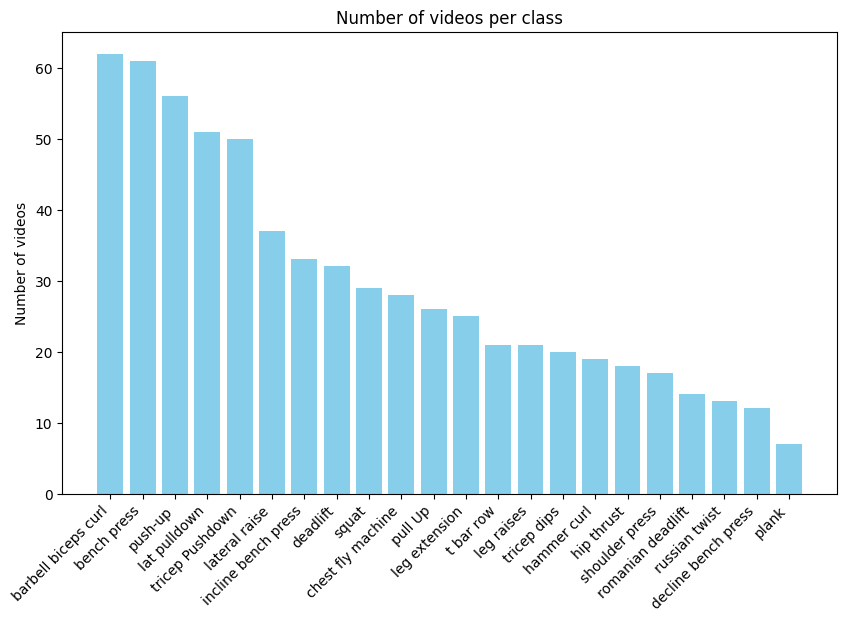

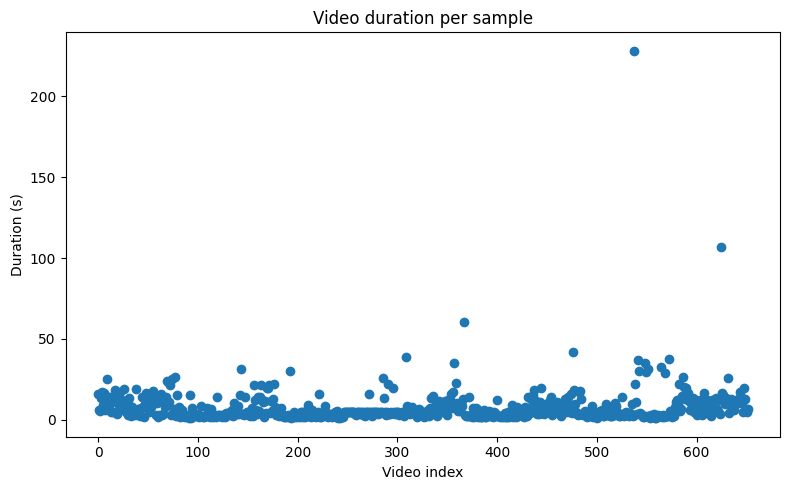

Minimum duration: 1.00
Maximum duration: 228.00
Mean duration: 7.86


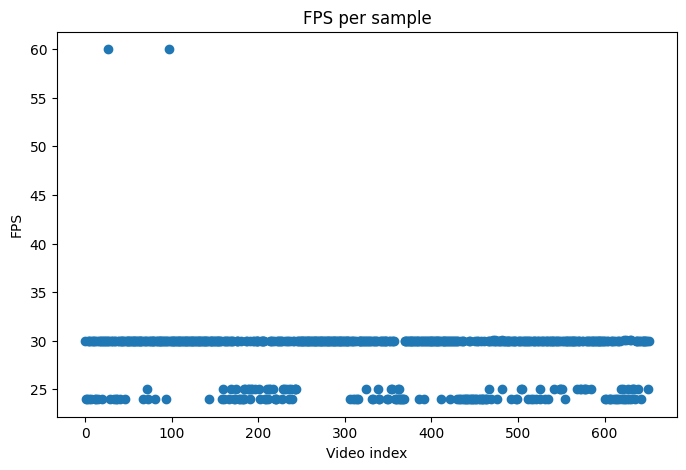

Minimum FPS: 23.98
Maximum FPS: 60.00


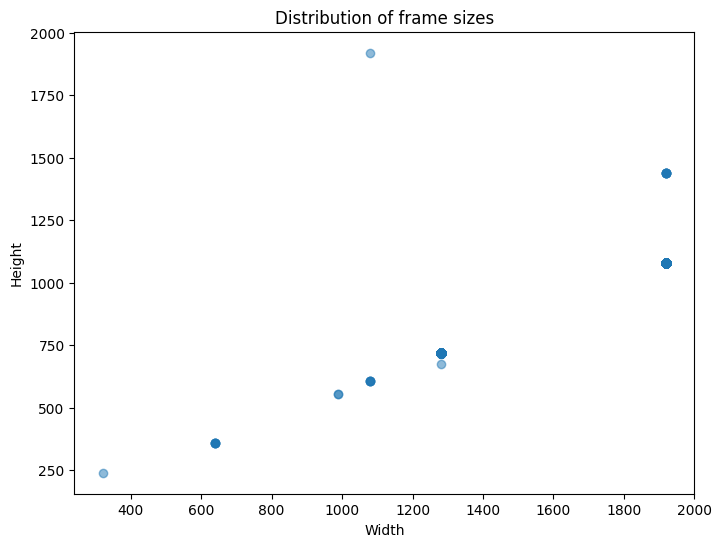

In [18]:
# Number of videos per class
counts = df['class'].value_counts()
plt.figure(figsize=(10,6))
plt.bar(counts.index, counts.values, color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of videos")
plt.title("Number of videos per class")
plt.show()

# Duration
plt.figure(figsize=(8,5))
plt.scatter(range(len(df)), df['duration_sec'])
plt.xlabel("Video index")
plt.ylabel("Duration (s)")
plt.title("Video duration per sample")
plt.tight_layout()
plt.show()

print(f"Minimum duration: {df['duration_sec'].min():.2f}")
print(f"Maximum duration: {df['duration_sec'].max():.2f}")
print(f"Mean duration: {df['duration_sec'].mean():.2f}")


# FPS distribution
plt.figure(figsize=(8,5))
plt.scatter(range(len(df)), df['fps'])
plt.xlabel("Video index")
plt.ylabel("FPS")
plt.title("FPS per sample")
plt.show()

print(f"Minimum FPS: {df['fps'].min():.2f}")
print(f"Maximum FPS: {df['fps'].max():.2f}")

# Frame sizes
plt.figure(figsize=(8,6))
plt.scatter(df['width'], df['height'], alpha=0.5)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Distribution of frame sizes")
plt.show()


## 2. Training model

### Hyperparameters

In [19]:
# Data preprocess
resizeframe=(112,112)
numframes=64

# Train test split
val_test_size=0.3
test_size=0.5
batchsize=16

# Model parameters
numepochs=30
learningrate=1e-4
weightdecay=5e-4

# Early stopping
minepochs=5
patience=3
mindelta=1e-2

### Train - Test split

In [20]:
train_df, temp_df = train_test_split(df,test_size=val_test_size,stratify=df["class"])
val_df, test_df = train_test_split(temp_df,test_size=test_size,stratify=temp_df["class"])

print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))

Train size: 456
Val size: 98
Test size: 98


### Pre process the video

In [21]:
class VideoDataset(Dataset):
    def __init__(self, df, class2idx,  resize=resizeframe, num_frames=numframes, is_train=True):
        """
        This class reads the video files and prepares them for model training, including preprocessing, frame sampling, and data augmentation.
        """
        self.resize = resize
        self.num_frames = numframes
        self.class2idx = class2idx
        self.is_train=is_train
        self.to_pil = T.ToPILImage()
        self.to_tensor = T.ToTensor()

        # Kinetics normalization
        self.mean = torch.tensor([0.43216, 0.394666, 0.37645]).view(3, 1, 1, 1)
        self.std = torch.tensor([0.22803, 0.22145, 0.216989]).view(3, 1, 1, 1)

        self.samples = []
        print("Preloading videos into memory...")
        for _, row in df.iterrows():
            video_path = row['file_path']
            label = self.class2idx[row['class']]
            frames_tensor = self._load_video(video_path)
            self.samples.append((frames_tensor, label))
        print(f"Done preloading {len(self.samples)} videos.")

    def _load_video(self, video_path):
        cap = cv2.VideoCapture(video_path)
        frames = []

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, self.resize)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = frame.astype("float32") / 255.0
            frames.append(frame)
        cap.release()

        # Number of frames available
        n_frames = len(frames)

        # Uniform sampling
        if n_frames >= self.num_frames:
            # indices spaced evenly across the video
            indices = np.linspace(0, n_frames-1, self.num_frames, dtype=int)
            frames = [frames[i] for i in indices]
        else:
            # Pad by repeating last frame
            pad = self.num_frames - n_frames
            frames = frames + [frames[-1]] * pad


       # Convert to tensor [C, T, H, W] without augmentation
        frames = [torch.from_numpy(f).permute(2, 0, 1) for f in frames]
        frames = torch.stack(frames, dim=1)
        return frames

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        frames, label = self.samples[idx]

        if self.is_train:
            # Apply spatial transforms
            # sample augmentation parameters ONCE per video
            do_flip = random.random() < 0.5
            brightness_factor = random.uniform(max(0, 1 - 0.2), 1 + 0.2)
            contrast_factor   = random.uniform(max(0, 1 - 0.2),   1 + 0.2)
            saturation_factor = random.uniform(max(0, 1 - 0.2), 1 + 0.2)
            hue_factor        = random.uniform(-0.1, 0.1)

            frames_aug = []
            # frames shape: (C, T, H, W)
            for f in frames.permute(1, 0, 2, 3):  # iterate over T
                img = self.to_pil(f)
                if do_flip:
                    img = F.hflip(img)

                img = F.adjust_brightness(img, brightness_factor)
                img = F.adjust_contrast(img, contrast_factor)
                img = F.adjust_saturation(img, saturation_factor)
                img = F.adjust_hue(img, hue_factor)
                img = self.to_tensor(img)
                frames_aug.append(img)

            frames = torch.stack(frames_aug, dim=1)

        # Normalize  after augmentation
        frames = (frames - self.mean) / self.std

        return frames, label

class_names = sorted(df["class"].unique())
Class2idx = {c: i for i, c in enumerate(class_names)}

train_dataset = VideoDataset(train_df, Class2idx, is_train=True)
val_dataset   = VideoDataset(val_df, Class2idx, is_train=False)
test_dataset  = VideoDataset(test_df, Class2idx, is_train=False)

Preloading videos into memory...
Done preloading 456 videos.
Preloading videos into memory...
Done preloading 98 videos.
Preloading videos into memory...
Done preloading 98 videos.


### Data loader + Weighted random sampler

In [22]:
# Count samples per class
class_counts = train_df["class"].value_counts().to_dict()
num_classes = len(class_names)

# Inverse frequency weights
class_weights = { Class2idx[c]: 1.0 / count for c, count in class_counts.items()}

sample_weights = train_df["class"].map(lambda c: class_weights[Class2idx[c]]).values
sample_weights = torch.DoubleTensor(sample_weights)
sampler = WeightedRandomSampler( weights=sample_weights,num_samples=len(sample_weights),replacement=True)

train_loader = DataLoader(train_dataset,batch_size=batchsize, sampler=sampler)
val_loader = DataLoader(val_dataset,batch_size=batchsize, shuffle=False)
test_loader = DataLoader(test_dataset,batch_size=batchsize,shuffle=False)

### Model

In [23]:
class Resnet3DVideoClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = r3d_18(weights="DEFAULT")
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes) # Replacing the FC layer
        for name, param in self.model.named_parameters():
            if  "layer3" in name or "layer4" in name or "fc" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

    def forward(self, x):
        return self.model(x)

### Training loop

In [24]:
def train_model(model, train_loader, val_loader, class_weights, device,learning_rate, weight_decay, num_epochs, min_epochs, patience, min_delta):
    """
    This function trains the model, validates it each epoch, and applies early stopping based on validation loss
    """
    # Prepare loss function
    weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))],dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)

    # Optimizer: only parameters with requires_grad=True
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=learning_rate, weight_decay=weight_decay)

    # Early stopping variables
    epochs_no_improve = 0
    best_model_state = None
    best_val_loss = float('inf')
    best_epoch = 0

    # History tracking
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        torch.cuda.empty_cache()

        # TRAIN
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()

            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct_train += (preds == y).sum().item()
            total_train += y.size(0)

        train_loss /= len(train_loader)
        train_acc = correct_train / total_train

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # VALIDATION
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = y.to(device)
                outputs = model(x)
                loss = criterion(outputs, y)

                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct_val += (preds == y).sum().item()
                total_val += y.size(0)

        val_loss /= len(val_loader)
        val_acc = correct_val / total_val

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] " f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | " f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # Save best model after min_epochs
        if epoch + 1 == min_epochs:
            best_model_state = model.state_dict()

        # Early stopping check after min_epochs
        if epoch >= min_epochs:
            if val_loss <  best_val_loss - min_delta:
                best_val_loss = val_loss
                best_epoch = epoch + 1
                best_model_state = model.state_dict()
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print(f"\nEarly stopping triggered at epoch {epoch + 1}. "
                      f"Best model corresponds to epoch {best_epoch}.")
                break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Loaded best model based on validation loss.")

    return model, history

### Train model

In [25]:
# Use GPU if avaliable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
torch.cuda.empty_cache()

model3D=Resnet3DVideoClassifier(num_classes).to(device)
model3D, history3D= train_model(model3D, train_loader, val_loader, class_weights, device, learningrate, weightdecay, numepochs, minepochs, patience, mindelta)

Device: cuda
Epoch [1/30] Train Loss: 2.0774 | Train Acc: 0.4254 | Val Loss: 1.7970 | Val Acc: 0.4184
Epoch [2/30] Train Loss: 0.8608 | Train Acc: 0.7544 | Val Loss: 1.0971 | Val Acc: 0.7347
Epoch [3/30] Train Loss: 0.3734 | Train Acc: 0.9211 | Val Loss: 0.8508 | Val Acc: 0.8571
Epoch [4/30] Train Loss: 0.2466 | Train Acc: 0.9518 | Val Loss: 0.5907 | Val Acc: 0.9388
Epoch [5/30] Train Loss: 0.1441 | Train Acc: 0.9825 | Val Loss: 0.5002 | Val Acc: 0.9286
Epoch [6/30] Train Loss: 0.1129 | Train Acc: 0.9912 | Val Loss: 0.4123 | Val Acc: 0.9490
Epoch [7/30] Train Loss: 0.0792 | Train Acc: 0.9912 | Val Loss: 0.3600 | Val Acc: 0.9490
Epoch [8/30] Train Loss: 0.0592 | Train Acc: 0.9912 | Val Loss: 0.3059 | Val Acc: 0.9592
Epoch [9/30] Train Loss: 0.0458 | Train Acc: 0.9978 | Val Loss: 0.3425 | Val Acc: 0.9490
Epoch [10/30] Train Loss: 0.0456 | Train Acc: 0.9934 | Val Loss: 0.2641 | Val Acc: 0.9694
Epoch [11/30] Train Loss: 0.0351 | Train Acc: 0.9978 | Val Loss: 0.2880 | Val Acc: 0.9490
Epoch 

## Plot train-val loss and acc

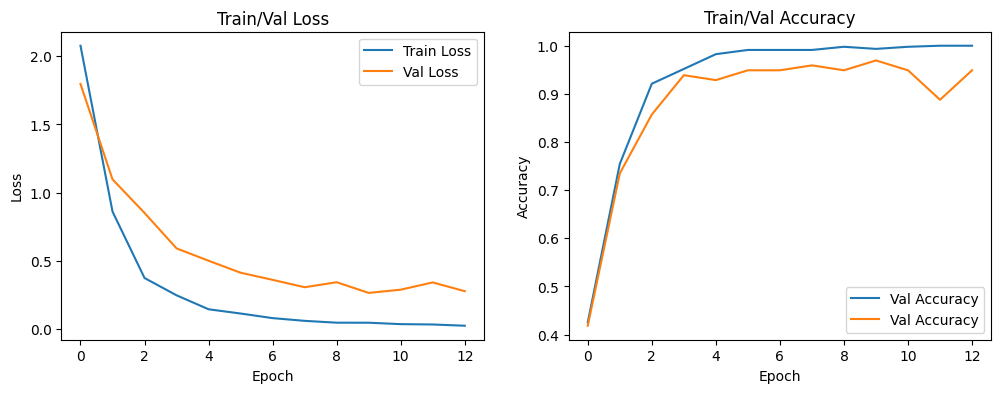

In [26]:
def plot_trainlval_loss_acc(history):
    train_losses=history['train_loss']
    val_losses=history['val_loss']
    train_accuracies=history['train_acc']
    val_accuracies=history['val_acc']

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train/Val Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_accuracies, label='Val Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train/Val Accuracy')
    plt.legend()

    plt.show()

plot_trainlval_loss_acc(history3D)

## Model evaluation

Test Accuracy: 0.9489795918367347


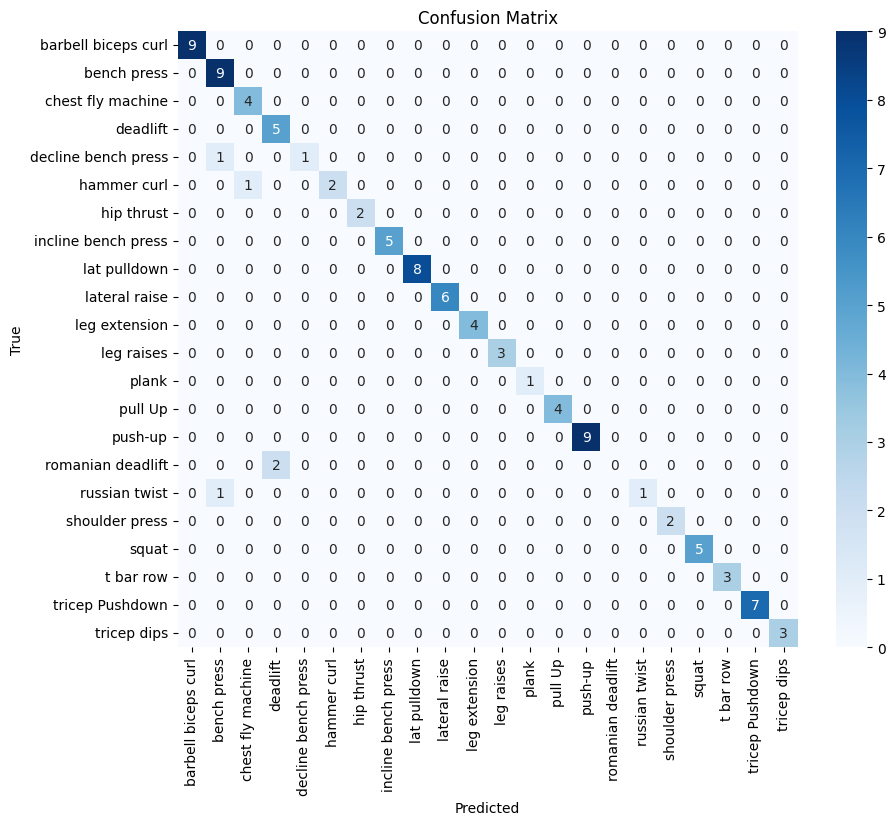

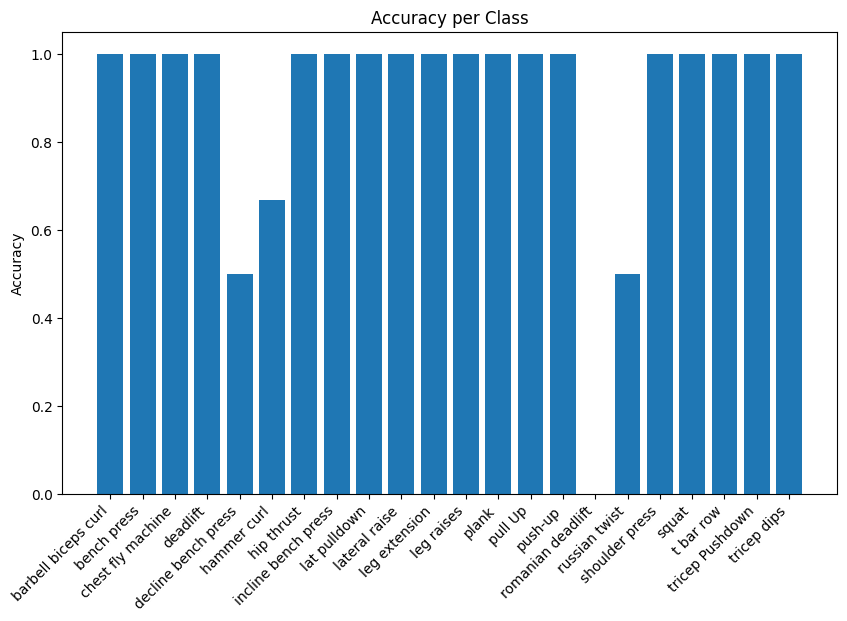

In [27]:
def modeleval_on_test(model, test_loader):
    """
    This function evaluate the model performace on the test set
    """
    model.eval()
    torch.cuda.empty_cache()
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())


    # Compute overall accuracy
    test_acc = accuracy_score(all_labels, all_preds)
    print("Test Accuracy:", test_acc)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Accuracy per class
    class_acc = cm.diagonal() / cm.sum(axis=1)
    plt.figure(figsize=(10,6))
    plt.bar(class_names, class_acc)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Accuracy")
    plt.title("Accuracy per Class")
    plt.show()

modeleval_on_test(model3D, test_loader)